In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan

In [2]:
def plot_trend(x_axis, y_axis):
    plt.plot(x_axis, y_axis)
    plt.rcParams['figure.figsize'] = (10,5)
    z = np.polyfit(x_axis, y_axis, 1)
    trend = np.poly1d(z)
    plt.plot(x_axis, trend(x_axis), 'r--')
    plt.xticks(np.arange(2006, 2018, 1))
    plt.xlabel('year')
    plt.ylabel('deaths')
    plt.show()

## Total number of death due to road traffic accidents in Finland

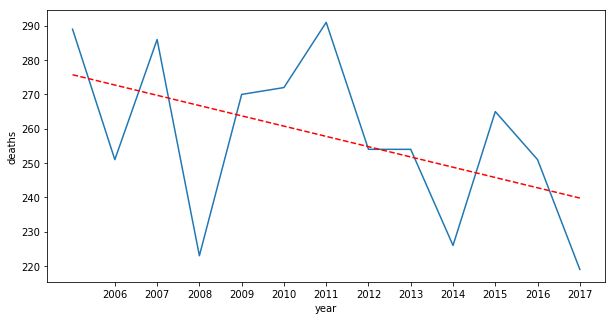

In [26]:
data = pd.read_csv('data/data.csv', sep = ',')
data['total']= data.iloc[:, 1:3].sum(axis=1)

years = data['year'].values
male = data['male'].values
female = data['female'].values
total_deaths = data['total'].values
prediction_year = 2018

plot_trend(years, total_deaths)

In [6]:
accidents_code = '''
data {
    int <lower=0> N;             //number of data points
    vector[N] year;              //observation year
    vector[N] number_of_deaths;  //total number of deaths
    real prediction_year;        //prediction year
}

parameters {
    real alpha;
    real beta;
    real <lower=0> sigma;
}

transformed parameters {
    vector[N] mu;
    mu = alpha + (beta * year);
}

model {
    beta ~ normal(0, 22);
    number_of_deaths ~ normal(mu, sigma);
}

generated quantities {
    real ypred;
    ypred = normal_rng(alpha + (beta * prediction_year), sigma);
}
'''
model = pystan.StanModel(model_code=accidents_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_185cd15b3b8ef48103538c27f8a82300 NOW.
/Users/maksaddonayorov/.virtualenvs/bda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/qn/_rqylh917b33tgzrfm1wy79h0000gn/T/tmphc_54key/stanfit4anon_model_185cd15b3b8ef48103538c27f8a82300_4545779191813139672.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [7]:
def stan_sampling_fit(deaths, years, year_to_predict):
    accidents_data = {
        'N': len(deaths),
        'year': years,
        'number_of_deaths': deaths,
        'prediction_year': year_to_predict
    }
    return model.sampling(data=accidents_data)

In [10]:
accidents_fit = stan_sampling_fit(total_deaths, years, prediction_year)
summary = accidents_fit.summary()
summary = pd.DataFrame(
    summary['summary'], 
    columns=summary['summary_colnames'], 
    index=summary['summary_rownames']
)

summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,6806.745347,467.284289,4285.360571,-1142.618482,4046.117013,6669.272838,9366.326641,15969.690352,84.103173,1.037480
beta,-3.256542,0.232353,2.130974,-7.816070,-4.526906,-3.188401,-1.884467,0.693131,84.112524,1.037468
sigma,25.484217,0.567313,6.419231,16.552903,21.003332,24.556310,28.831030,40.900018,128.032640,1.023198
mu[1],277.377873,1.415777,14.604621,249.116589,268.269709,276.807807,286.295282,308.418003,106.412072,1.031265
mu[2],274.121330,1.182555,12.786147,249.208042,266.175187,273.654642,281.835953,300.940341,116.906035,1.028742
mu[3],270.864788,0.948397,11.079631,249.150253,263.785721,270.598445,277.643832,294.262337,136.480383,1.025029
mu[4],267.608246,0.711680,9.545313,248.906060,261.606127,267.415023,273.358417,288.082905,179.891727,1.019653
mu[5],264.351703,0.462079,8.279486,248.209853,259.134341,264.203656,269.276507,281.805398,321.050538,1.012463
mu[6],261.095161,0.211408,7.420839,246.690710,256.409706,261.079677,265.553457,276.563638,1232.148089,1.004746
mu[7],257.838618,0.114558,7.118281,243.895074,253.426007,257.830048,262.407331,272.234073,3861.021187,1.000067


#### Predictions for total number of deaths in 2018

In [15]:
def plot_perdiction_histogram(fit, xlim, xticks):
    y_pred = fit.extract()['ypred']
    plt.hist(y_pred, bins=40, ec='white', alpha=0.7)
    plt.xlim(xlim[0], xlim[1])
    plt.xticks(xticks)
    plt.show()

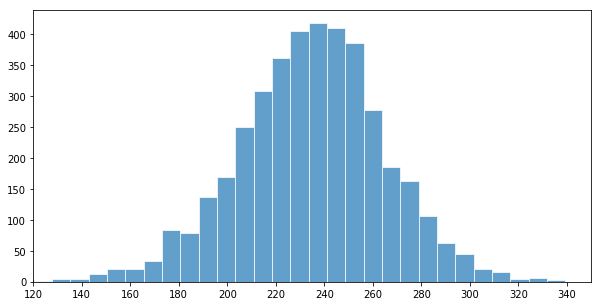

In [35]:
plot_perdiction_histogram(
    accidents_fit, 
    xlim=[120, 350], 
    xticks=np.arange(120, 360, 20)
)

## Male death due to road traffic accidents in Finland

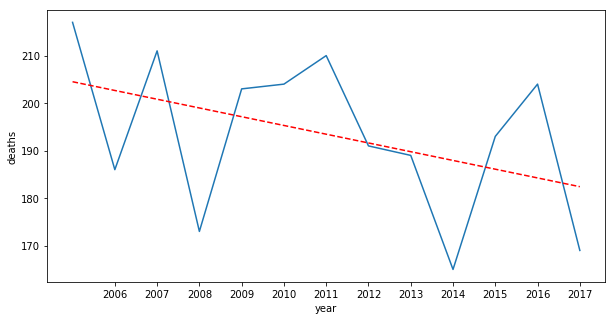

In [27]:
plot_trend(years, male)

In [14]:
accidents_fit_male = stan_sampling_fit(male, years, prediction_year)
summary_male = accidents_fit_male.summary()
summary_male = pd.DataFrame(
    summary_male['summary'], 
    columns=summary_male['summary_colnames'], 
    index=summary_male['summary_rownames']
)

summary_male

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,3982.115319,184.032883,2751.390403,-1797.535784,2204.395714,3967.261932,5760.474171,9437.892276,223.518554,1.033973
beta,-1.883989,0.091535,1.368173,-4.595345,-2.767944,-1.877040,-0.998117,0.988174,223.410027,1.033979
sigma,18.142869,0.264694,4.645643,11.456520,14.860719,17.268602,20.567506,29.600463,308.038133,1.017272
mu[1],204.716562,0.544995,9.721804,185.194192,198.682374,204.647232,210.925762,224.440915,318.205939,1.022599
mu[2],202.832572,0.455585,8.599340,185.478882,197.455693,202.734672,208.324560,220.136383,356.280247,1.019761
mu[3],200.948583,0.366734,7.558282,185.725167,196.212072,200.770264,205.667493,215.982719,424.760574,1.016016
mu[4],199.064594,0.278871,6.637047,185.850911,194.968326,198.973107,203.179682,212.326002,566.425575,1.011279
mu[5],197.180604,0.192913,5.892110,185.360254,193.490846,197.114703,200.819598,208.748939,932.864836,1.005946
mu[6],195.296615,0.108230,5.396973,184.504352,191.953312,195.321308,198.685610,205.768987,2486.595358,1.001441
mu[7],193.412625,0.084273,5.223166,182.773323,190.256615,193.477641,196.638814,203.797828,3841.435743,1.000031


#### Predictions for number of male deaths in 2018

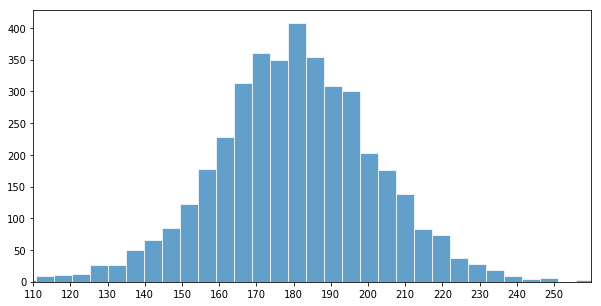

In [33]:
plot_perdiction_histogram(
    accidents_fit_male, 
    xlim=[110, 260], 
    xticks=np.arange(110, 260, 10)
)

## Female death due to road traffic accidents in Finland

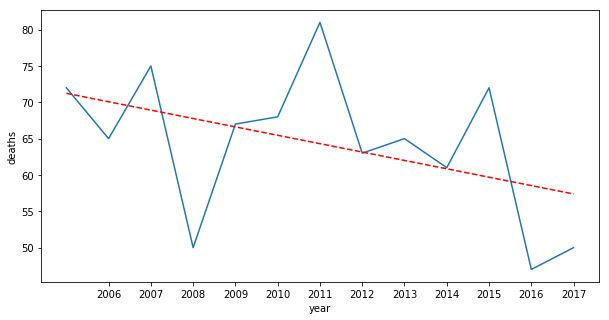

In [28]:
plot_trend(years, female)

In [21]:
accidents_fit_female = stan_sampling_fit(female, years, prediction_year)
summary_female = accidents_fit_female.summary()
summary_female = pd.DataFrame(
    summary_female['summary'], 
    columns=summary_female['summary_colnames'], 
    index=summary_female['summary_rownames']
)

summary_female

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,2055.616203,124.455409,1694.081357,-1712.765528,1041.460257,2111.506938,3149.862736,5341.539035,185.285302,1.004458
beta,-0.990206,0.061884,0.842391,-2.624376,-1.534026,-1.018041,-0.485162,0.884876,185.300297,1.004456
sigma,10.941985,0.152894,2.684024,7.116695,9.073136,10.501337,12.271927,17.455168,308.172392,1.010866
mu[1],70.252302,0.381303,5.922981,57.635105,66.674413,70.292016,74.137296,81.494292,241.290744,1.004390
mu[2],69.262096,0.319804,5.217580,58.299236,66.049521,69.322885,72.695034,79.247582,266.176701,1.004231
mu[3],68.271890,0.258603,4.558927,58.957179,65.395500,68.316885,71.203435,77.044631,310.783689,1.003979
mu[4],67.281683,0.197713,3.970357,59.352765,64.753565,67.345216,69.809296,75.069064,403.262238,1.003586
mu[5],66.291477,0.136570,3.487535,59.327798,64.067152,66.327714,68.493228,73.225133,652.120440,1.003016
mu[6],65.301270,0.080281,3.159321,58.830078,63.305188,65.345021,67.239656,71.646837,1548.692411,1.002323
mu[7],64.311064,0.051830,3.036274,58.090511,62.441459,64.332555,66.208645,70.355874,3431.784637,1.001736


### Predictions for number of female deaths in 2018

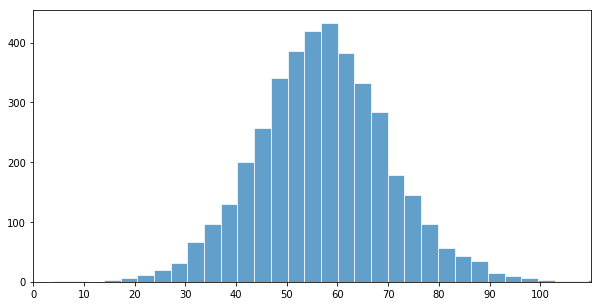

In [32]:
plot_perdiction_histogram(
    accidents_fit_female, 
    xlim=[0, 110], 
    xticks=np.arange(0, 110, 10)
)